In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import os
import joblib

In [ ]:
df=pd.read_csv('Data_Sets\SuperMarket Analysis.csv')

In [ ]:
df.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [ ]:
df.duplicated().sum()
df.info()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [5]:
# Adding a column to know which row belong to which dataset
train['source']='train'
test['source']='test'



In [6]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train


In [7]:
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,source
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3,test
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3,test
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1,test
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2,test
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3,test


In [8]:
combined=pd.concat([train,test],ignore_index=True)

In [9]:
# Sales column will consist of NaN for test data

In [10]:
combined.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train


In [11]:
combined.isna().sum()

Item_ID                     0
Item_W                      0
Item_Type                   0
Item_MRP                    0
Outlet_ID                   0
Outlet_Year                 0
Outlet_Size                 0
Outlet_Location_Type        0
Sales                   37656
source                      0
dtype: int64

In [12]:
combined.duplicated().sum()

np.int64(0)

In [13]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125520 entries, 0 to 125519
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Item_ID               125520 non-null  object 
 1   Item_W                125520 non-null  float64
 2   Item_Type             125520 non-null  object 
 3   Item_MRP              125520 non-null  float64
 4   Outlet_ID             125520 non-null  object 
 5   Outlet_Year           125520 non-null  int64  
 6   Outlet_Size           125520 non-null  object 
 7   Outlet_Location_Type  125520 non-null  object 
 8   Sales                 87864 non-null   float64
 9   source                125520 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 9.6+ MB


In [14]:
# Spliting the two tables based on column source
train_cleaned = combined[combined['source'] == 'train'].copy()
test_cleaned = combined[combined['source'] == 'test'].copy()


In [15]:
print(train_cleaned.shape)
print(test_cleaned.shape)

print(train_cleaned.columns)
print(test_cleaned.columns)


(87864, 10)
(37656, 10)
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Sales',
       'source'],
      dtype='object')
Index(['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID',
       'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Sales',
       'source'],
      dtype='object')


In [16]:
train_cleaned.drop(columns=['source'],inplace=True)
test_cleaned.drop(columns=['source'],inplace=True)
# Might need to frop Sales from test

In [17]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [18]:
test_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
87864,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3,NaN
87865,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3,NaN
87866,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1,NaN
87867,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2,NaN
87868,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3,NaN


## EDA

##### Univariate Analysis

In [19]:
num_cols=train_cleaned.select_dtypes(include=['number','int','float'])
cat_cols=train_cleaned.select_dtypes(exclude=['number','int','float'])

In [20]:
num_cols.columns

Index(['Item_W', 'Item_MRP', 'Outlet_Year', 'Sales'], dtype='object')

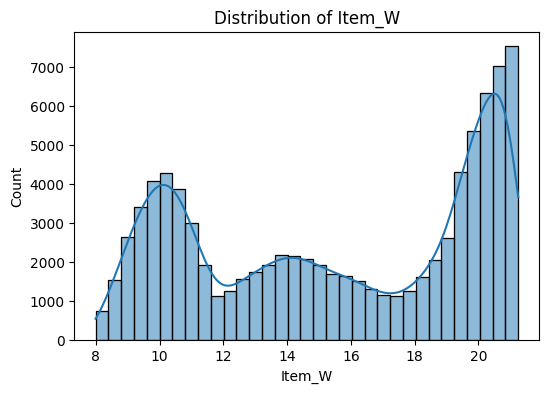

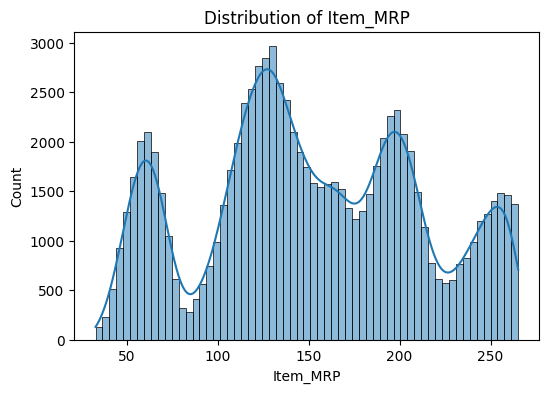

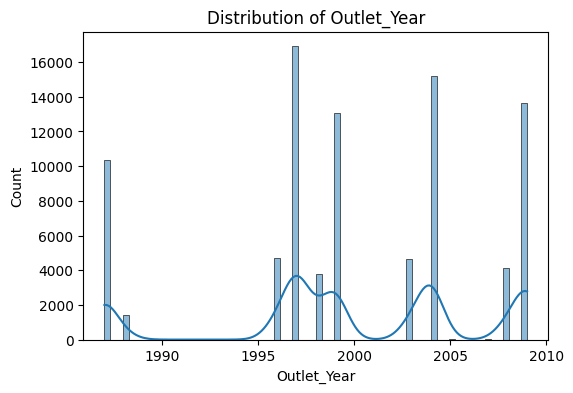

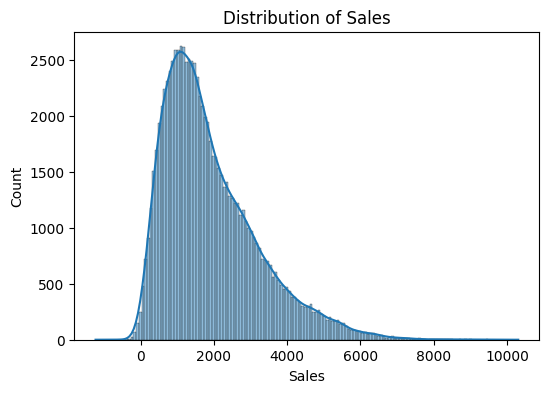

In [21]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [22]:
from scipy.stats import skew
print("Skewness:", skew(num_cols['Sales']))

Skewness: 1.125429741747798


In [23]:
num_cols['Sales'].describe()
#The output shows that the min value is negative we have to deal with that before appling log transformation

count    87864.000000
mean      1911.842120
std       1291.386004
min      -1229.360345
25%        959.249675
50%       1606.307877
75%       2608.057736
max      10309.283310
Name: Sales, dtype: float64

In [24]:
# Skewness 1.125 means that the target column is right skewed, hence we use log transformation to make it normal

In [25]:
train_cleaned['Sales'].dtype
# train_cleaned['Sales'].head(10)
train_cleaned['Sales'].tail(10)


87854    1299.153182
87855    1555.438078
87856    4091.864332
87857    -230.043351
87858    4745.822400
87859    4975.646052
87860    2252.492755
87861    2716.058050
87862     991.857233
87863    4260.617470
Name: Sales, dtype: float64

In [26]:
import numpy as np

print("NaN count:", train_cleaned['Sales'].isna().sum())
print("inf count:", np.isinf(train_cleaned['Sales']).sum())

# Check for invalid numeric representations
weird_mask = ~np.isfinite(train_cleaned['Sales'])
print("Weird (non-finite) count:", weird_mask.sum())

# Check for really small rounding artifacts
min_val = train_cleaned['Sales'].min()
print("True min:", min_val)
print("Any values < 0.0000001:", (train_cleaned['Sales'] < 0.0000001).sum())


NaN count: 0
inf count: 0
Weird (non-finite) count: 0
True min: -1229.3603449999998
Any values < 0.0000001: 397


In [27]:
#Output shows the columns with negative Sales value
print(train_cleaned['Sales'].dtype)
train_cleaned[train_cleaned['Sales'] < 0].head()


float64


,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
102,FDI14,20.996995,Meat,191.974325,OUT046,1987,Small,Tier 2,-46.046126
133,FDZ52,20.873340,Others,149.528575,OUT049,1987,Small,Tier 2,-25.433674
892,FDN12,20.407615,Starchy Foods,110.410412,OUT049,1999,Small,Tier 2,-4.505521
976,DRE48,20.004882,Hard Drinks,142.408146,OUT049,1997,Small,Tier 2,-2.610184
1179,FDA39,19.945005,Baking Goods,176.576055,OUT035,1997,Small,Tier 1,-64.609374


In [28]:
#Research This!!!
train_cleaned['Sales'] = pd.to_numeric(train_cleaned['Sales'], errors='coerce')
train_cleaned.loc[train_cleaned['Sales'] < 0, 'Sales'] = 0


In [29]:
train_cleaned['Sales'].min()
# (train_cleaned['Sales'] < 0).sum()


np.float64(0.0)

In [30]:
train_cleaned['Sales'].dtype

dtype('float64')

In [31]:
train_cleaned.describe()

,Item_W,Item_MRP,Outlet_Year,Sales
count,87864.000000,87864.000000,87864.00000,87864.000000
mean,15.591469,151.242943,1999.87063,1912.279230
std,4.364429,59.536366,6.63429,1290.699692
min,7.992700,32.910015,1987.00000,0.000000
25%,10.968658,112.423337,1997.00000,959.249675
50%,15.831170,145.581473,1999.00000,1606.307877
75%,19.969936,197.110367,2004.00000,2608.057736
max,21.250000,265.214271,2009.00000,10309.283310


In [32]:
train_cleaned['Sales'].isna().sum(), np.isinf(train_cleaned['Sales']).sum()


(np.int64(0), np.int64(0))

In [33]:
# Skewness 1.125 means that the target column is right skewed, hence we use log transformation to make it normal

In [34]:
# train_cleaned['Sales_transformed'] = np.log1p(num_cols['Sales'])

In [35]:
# plt.figure(figsize=(6,4))
# sns.histplot(train_cleaned['Sales_transformed'], kde=True)
# plt.title(f'Distribution of {col}')
# plt.show()

In [36]:
# from scipy.stats import skew
# print(skew(train_cleaned['Sales_transformed']))

In [37]:
train_cleaned.isna().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
Sales                   0
dtype: int64

In [38]:
# num_cols['Sales_transformed'].describe()


In [39]:
# using powertransformer to handle skeweness

In [40]:
#Skip for now
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson')
# train_cleaned['Sales_transformed'] = pt.fit_transform(num_cols[['Sales']])


In [41]:
# plt.figure(figsize=(5,6))
# sns.histplot(train_cleaned['Sales_transformed'], kde=True)
# plt.title(f'Distribution of {col}')
# plt.show()

In [42]:
# print(skew(train_cleaned['Sales_transformed']))

In [43]:
num_cols=train_cleaned.select_dtypes(include=['int','float','number'])

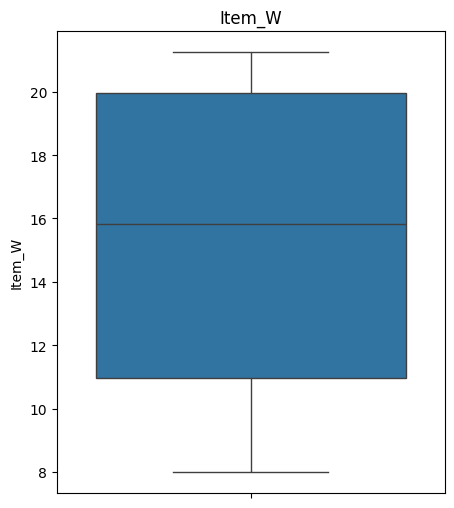

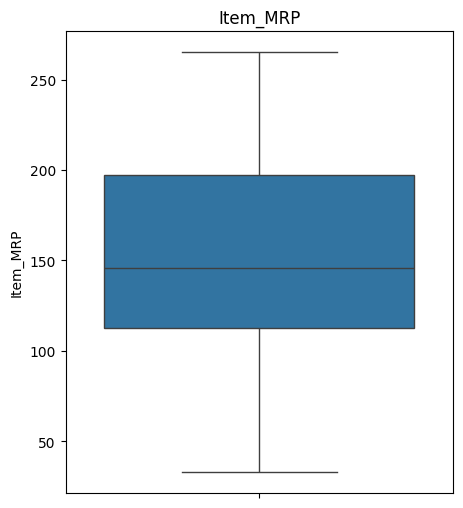

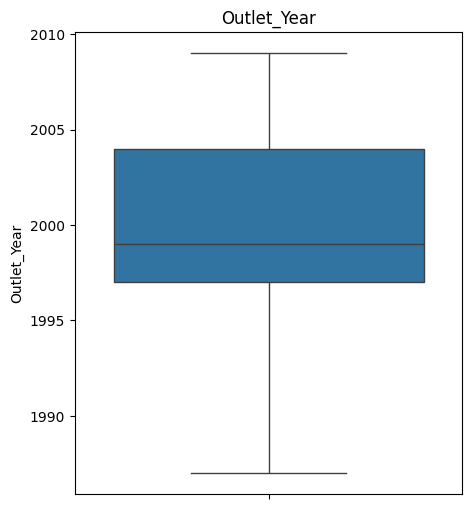

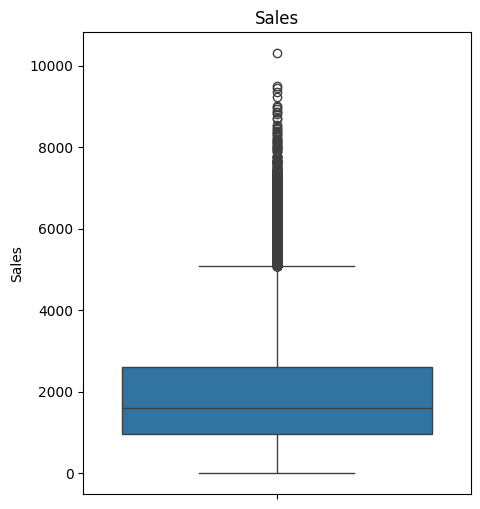

In [44]:
for col in num_cols:
    plt.figure(figsize=(5,6))
    sns.boxplot(num_cols[col])
    plt.title(col)
    plt.show()

In [45]:
# We can see that there are outliers present in the target column

In [46]:
# import numpy as np

# Q1 = num_cols['Sales_transformed'].quantile(0.25)
# Q3 = num_cols['Sales_transformed'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = num_cols[(num_cols['Sales_transformed'] < lower_bound) | (num_cols['Sales_transformed'] > upper_bound)]
# print(f"Outlier count: {len(outliers)} ({len(outliers)/len(num_cols)*100:.2f}% of data)")


In [47]:
# To deal with outlier we use Winsorization

# Winsorization is a statistical technique used to limit the influence of extreme values (outliers)
#  by capping them at specific percentile thresholds — rather than removing them.
# It brings extreme values closer to the bulk of the data, instead of deleting them.


In [48]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [49]:
#Skip for now
# from scipy.stats.mstats import winsorize
# train_cleaned['Sales_transformed_capped']=winsorize(train_cleaned['Sales_transformed'],limits=[0.01,0.01])


In [50]:
#For Model training without winsortization part
# train_cleaned['Sales_transformed_capped']=train_cleaned['Sales_transformed']
train_cleaned['Sales_transformed_capped']=train_cleaned['Sales']

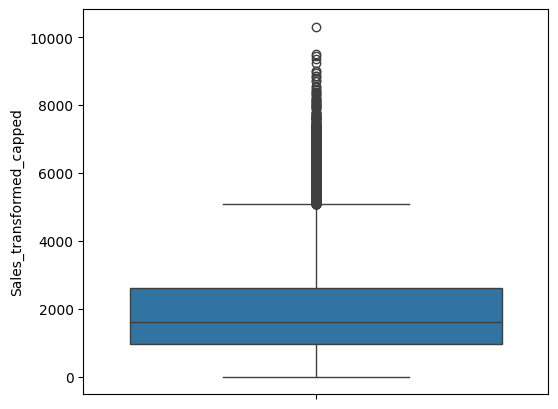

In [51]:
plt.figure(figsize=(6,5))
sns.boxplot(train_cleaned['Sales_transformed_capped'])
plt.show()

In [52]:
cat_cols.head()

,Item_ID,Item_Type,Outlet_ID,Outlet_Size,Outlet_Location_Type
0,FDU32,Baking Goods,OUT046,Small,Tier 2
1,NCT54,Meat,OUT035,Small,Tier 1
2,FDW08,Hard Drinks,OUT035,Small,Tier 3
3,FDJ22,Starchy Foods,OUT046,Small,Tier 1
4,FDF47,Baking Goods,OUT035,Small,Tier 3


In [53]:
for col in cat_cols:
    vc = train_cleaned[col].value_counts() # counts how many times each unique category appears in that column.
    pct = train_cleaned[col].value_counts(normalize=True).mul(100)#finds what percentage of total data each represents.
    summary = pd.concat([vc, pct], axis=1)# axis=1 means to concatenate horizontally
    summary.columns = ['count','percent']
    print(f"\n=== {col} ===")
    print(summary)



=== Item_ID ===
         count   percent
Item_ID                 
FDE11      419  0.476873
NCE07      362  0.412000
NCL18      346  0.393790
NCO06      336  0.382409
FDD51      329  0.374442
...        ...       ...
DRF60        2  0.002276
FDC32        2  0.002276
FDI12        2  0.002276
FDA22        1  0.001138
NCM19        1  0.001138

[895 rows x 2 columns]

=== Item_Type ===
                       count    percent
Item_Type                              
Baking Goods           14666  16.691705
Fruits and Vegetables  14328  16.307020
Meat                    8099   9.217655
Snack Foods             7817   8.896704
Household               6018   6.849222
Soft Drinks             5396   6.141309
Frozen Foods            5129   5.837431
Canned                  4565   5.195529
Dairy                   3807   4.332833
Others                  3688   4.197396
Breads                  3509   3.993672
Hard Drinks             3129   3.561185
Health and Hygiene      2995   3.408677
Starchy Foods  

-Bivariate Data

Regression Line


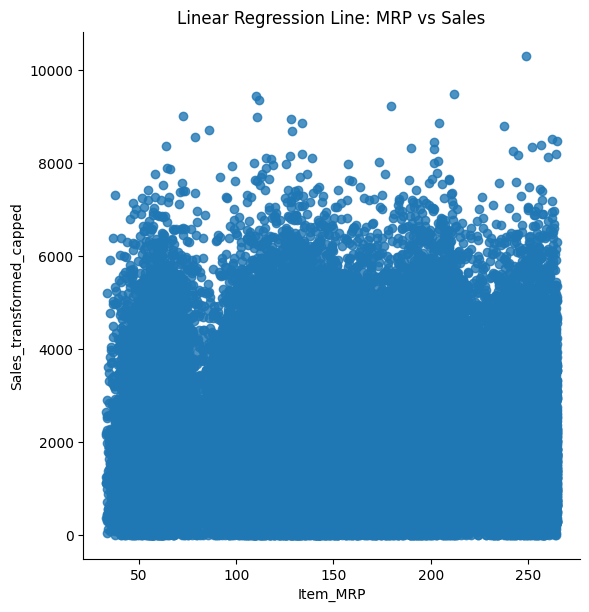

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume train_processed has been preprocessed
numeric_cols = train_cleaned.select_dtypes(include=['float64','int64']).columns

# Compute correlation matrix
corr_matrix = train_cleaned[numeric_cols].corr()

#Regression line plot
sns.lmplot(x='Item_MRP', y='Sales_transformed_capped', data=train_cleaned, height=6)
plt.title("Linear Regression Line: MRP vs Sales")
plt.show()



Scatter Plot


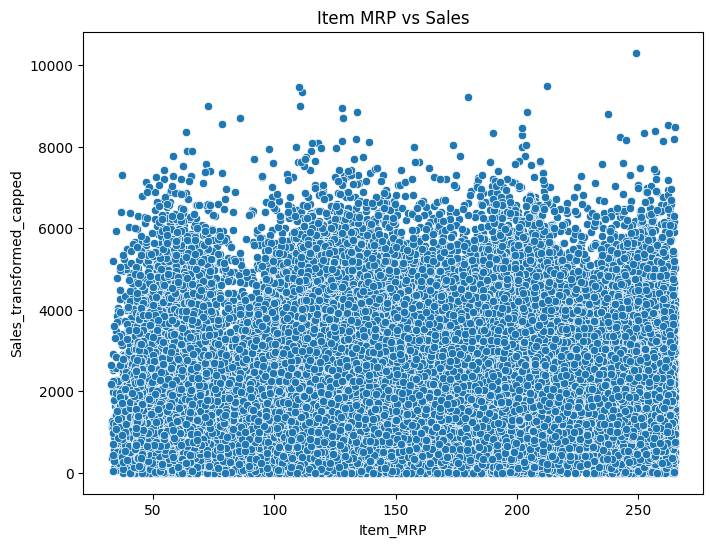

In [55]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Item_MRP', y='Sales_transformed_capped', data=train_cleaned)
plt.title("Item MRP vs Sales")
plt.show()


Box plot


To see the sales in outlet location types


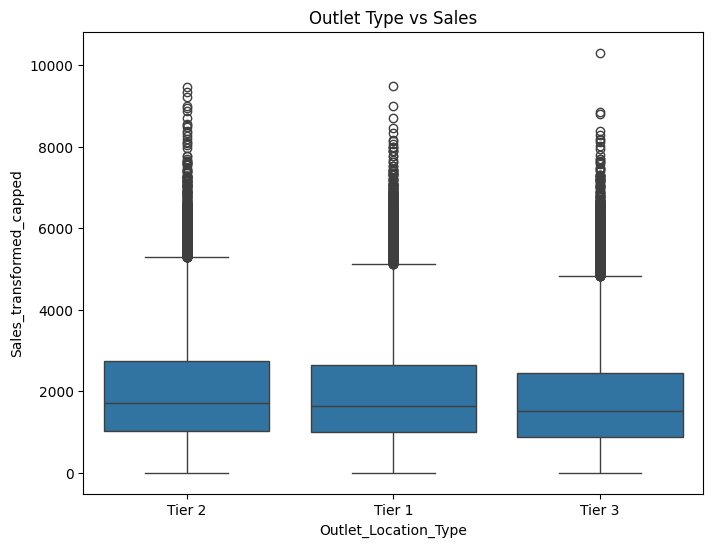

In [56]:
categorical_cols = train_cleaned.select_dtypes(include=['object']).columns

# Example: How Outlet_Location_Type affects Sales
plt.figure(figsize=(8,6))
sns.boxplot(x='Outlet_Location_Type', y='Sales_transformed_capped', data=train_cleaned)
plt.title("Outlet Type vs Sales")
plt.show()

In [57]:
# plt.figure(figsize=(5,6))
# sns.barplot(x='Item_Type', y='Sales_transformed_capped', data=train_cleaned)
# plt.show()

In [58]:
num_cols.columns

Index(['Item_W', 'Item_MRP', 'Outlet_Year', 'Sales'], dtype='object')

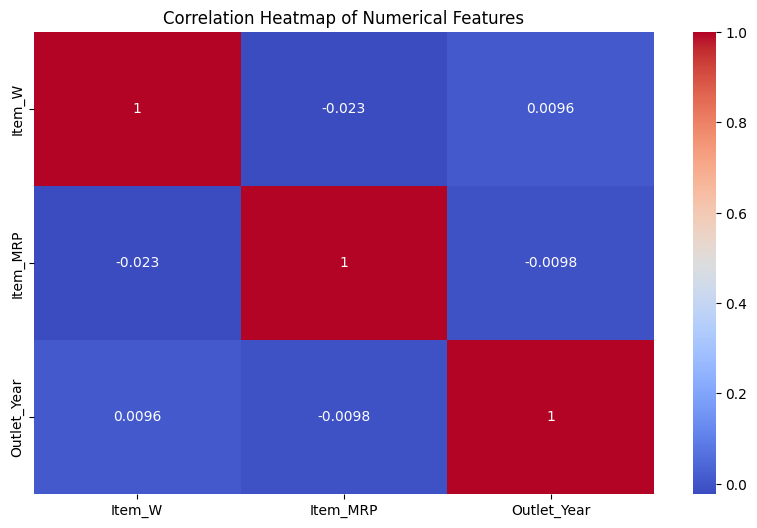

In [59]:
num_cols.drop(columns=['Sales'],inplace=True)
plt.figure(figsize=(10,6))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [60]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Sales_transformed_capped
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,1739.769829


In [61]:
# Compute outlet age and drop Outlet_Year (feature engineering)
train_cleaned['Outlet_Age'] = 2025 - train_cleaned['Outlet_Year']
train_cleaned.drop('Outlet_Year', axis=1, inplace=True)


In [62]:
train_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Size,Outlet_Location_Type,Sales,Sales_transformed_capped,Outlet_Age
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,Small,Tier 2,2689.457781,2689.457781,21
1,NCT54,21.102371,Meat,148.250214,OUT035,Small,Tier 1,3437.350375,3437.350375,38
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,Small,Tier 3,3129.967268,3129.967268,26
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,Small,Tier 1,1306.514376,1306.514376,29
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,Small,Tier 3,1739.769829,1739.769829,37


In [63]:
num_cols=train_cleaned.select_dtypes(include=['int','float','number'])


In [64]:
num_cols.head()

,Item_W,Item_MRP,Sales,Sales_transformed_capped,Outlet_Age
0,21.027499,197.352319,2689.457781,2689.457781,21
1,21.102371,148.250214,3437.350375,3437.350375,38
2,20.882263,205.465010,3129.967268,3129.967268,26
3,21.050435,253.417583,1306.514376,1306.514376,29
4,21.247876,240.871039,1739.769829,1739.769829,37


In [65]:
test_cleaned.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
87864,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3,NaN
87865,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3,NaN
87866,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1,NaN
87867,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2,NaN
87868,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3,NaN


In [66]:
# test_cleaned['Outlet_Age'] = 2025 - test_cleaned['Outlet_Year']
# test_cleaned.drop('Outlet_Year', axis=1, inplace=True)

### Feature Engineering

In [67]:
# Item Category
# Extract first two letters from Item_ID to classify into Food/Drinks/Non-Consumable

combined['Item_Category'] = combined['Item_ID'].str[:2].map({
    'FD': 'Food',
    'DR': 'Drinks',
    'NC': 'Non-Consumable'
})


# Interaction Feature
# IT refers to new features created by combining two or more existing features in a way that captures their relationship or interaction
# Numerical Columns
# 1. Relationship between item price and weight
combined['MRP_Weight'] = combined['Item_MRP'] * combined['Item_W']

#2.Item MRP × Sales:
combined['MRP_Sales_interaction'] = combined['Item_MRP'] * combined['Sales']

# 3. Item MRP × Outlet Year
combined['MRP_OutletYear_interaction'] = combined['Item_MRP'] * combined['Outlet_Year']

#4. Sales × MRP Weight

combined['Sales_MRPWeight_interaction']= combined['Sales'] * combined['MRP_Weight']

# Categorical Columns
# -------------------------------------------------------------------
#Research Polynomial Features

In [68]:
combined.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source,Item_Category,MRP_Weight,MRP_Sales_interaction,MRP_OutletYear_interaction,Sales_MRPWeight_interaction
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train,Food,4149.825748,530770.730202,395494.047476,1.116078e+07
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train,Non-Consumable,3128.430955,509587.927656,294573.174622,1.075351e+07
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train,Food,4290.574433,643098.754454,410724.553990,1.342936e+07
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train,Food,5334.550315,331093.715582,505821.496067,6.969667e+06
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train,Food,5117.998055,419060.166680,478851.625930,8.904139e+06


In [69]:
train_cleaned.drop('Item_ID', axis=1, inplace=True)
test_cleaned.drop('Item_ID', axis=1, inplace=True)


In [70]:
# Doing one-hot separately on train and test can create mismatched columns.
# One-hot encode 'Item_Type' on the combined dataframe so both train and test get the same dummy columns.
combined = pd.get_dummies(combined, columns=['Item_Type'], drop_first=True)

# After this operation, all Item_Type dummies exist in `combined` for both train and test rows.


In [71]:
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,source
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,train
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,train
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,train
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376,train
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829,train


In [72]:
# fitting on train and transforming test separately may be okay for label encoding,
# but doing all encodings on `combined` ensures absolute consistency for all categorical transforms.
# Label-encode 'Outlet_ID' on combined so encoding is consistent across train/test
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combined['Outlet_ID'] = le.fit_transform(combined['Outlet_ID'].astype(str))

# Now that we've applied all encodings on `combined`, re-split into train_cleaned and test_cleaned
# This ensures the encoded columns appear exactly the same in both sets.
train_cleaned = combined[combined['source'] == 'train'].copy()
test_cleaned = combined[combined['source'] == 'test'].copy()

# If 'Sales_transformed_capped' was previously created for modeling, ensure it exists for train
# If not present yet, create it by copying 'Sales' (this was your previous simple approach)
if 'Sales_transformed_capped' not in train_cleaned.columns:
    train_cleaned['Sales_transformed_capped'] = train_cleaned['Sales']

# Drop the helper 'source' column now that we've re-split (keeps dataframes clean)
train_cleaned.drop(columns=['source'], inplace=True)
test_cleaned.drop(columns=['source'], inplace=True)


In [73]:
train_cleaned.head()

,Item_ID,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Category,MRP_Weight,...,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Sales_transformed_capped
0,FDU32,21.027499,197.352319,3,2004,Small,Tier 2,2689.457781,Food,4149.825748,...,False,False,False,False,False,False,False,False,False,2689.457781
1,NCT54,21.102371,148.250214,2,1987,Small,Tier 1,3437.350375,Non-Consumable,3128.430955,...,False,False,False,True,False,False,False,False,False,3437.350375
2,FDW08,20.882263,205.465010,2,1999,Small,Tier 3,3129.967268,Food,4290.574433,...,True,False,False,False,False,False,False,False,False,3129.967268
3,FDJ22,21.050435,253.417583,3,1996,Small,Tier 1,1306.514376,Food,5334.550315,...,False,False,False,False,False,False,False,False,True,1306.514376
4,FDF47,21.247876,240.871039,2,1988,Small,Tier 3,1739.769829,Food,5117.998055,...,False,False,False,False,False,False,False,False,False,1739.769829


In [74]:
test_cleaned.head()

,Item_ID,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Category,MRP_Weight,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
87864,DRM23,10.156725,119.319482,0,1999,High,Tier 3,NaN,Drinks,1211.895191,...,False,False,False,False,False,False,False,True,False,False
87865,FDG47,10.434425,263.600449,1,1987,High,Tier 3,NaN,Food,2750.519062,...,False,False,False,True,False,False,False,False,False,False
87866,FDN21,11.953589,246.286990,1,1997,High,Tier 1,NaN,Food,2944.013353,...,False,False,True,False,False,False,False,False,False,False
87867,FDZ23,14.948546,136.200508,3,2004,Medium,Tier 2,NaN,Food,2035.999505,...,False,False,False,False,False,False,False,False,False,False
87868,FDC16,11.080042,173.145664,1,2009,Medium,Tier 3,NaN,Food,1918.461259,...,False,False,False,False,False,False,False,False,False,False


In [75]:
train_cleaned['Sales_transformed_capped']

0        2689.457781
1        3437.350375
2        3129.967268
3        1306.514376
4        1739.769829
            ...     
87859    4975.646052
87860    2252.492755
87861    2716.058050
87862     991.857233
87863    4260.617470
Name: Sales_transformed_capped, Length: 87864, dtype: float64

In [76]:
# Separate features (X) and target (y)
X_train = train_cleaned.drop('Sales_transformed_capped', axis=1)
y_train = train_cleaned['Sales_transformed_capped']

# Test set (without target)
X_test = test_cleaned

# DIAGNOSTIC: Check X_train before dropping leakage columns
print("X_train shape before leakage drops:", X_train.shape)
print("X_train columns before leakage drops:")
print(X_train.columns.tolist())

# Prevent target leakage: drop any original target columns and ID columns from feature set
# ID columns (Item_ID, Outlet_ID, Outlet_Year) are identifiers, not predictive features.
# Outlet_Year should have been dropped earlier but may still be present.
columns_to_drop = []
for col in ['Sales', 'Sales_transformed', 'Item_ID', 'Outlet_ID', 'Outlet_Year']:
    if col in X_train.columns:
        columns_to_drop.append(col)

if columns_to_drop:
    X_train = X_train.drop(columns=columns_to_drop)
    print(f"\nDropped leakage/ID columns from X_train: {columns_to_drop}")

# DIAGNOSTIC: Check X_train after dropping leakage columns
print("\nX_train shape after leakage drops:", X_train.shape)
print("X_train columns after leakage drops:")
print(X_train.columns.tolist())

# The previous code attempted to scale X_train directly with StandardScaler:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# That failed because X_train still contained non-numeric columns (strings like 'FDU32'),
# which can't be converted to floats. We must transform categorical columns before scaling.

# Robust preprocessing pipeline:
# - Impute numeric columns with median, then StandardScale them
# - Impute categorical columns with most frequent value, then OneHotEncode (handle_unknown='ignore')
# - Use ColumnTransformer to apply transformations and produce a numeric array for modeling

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify numeric and categorical columns
# IMPORTANT: Include 'bool' in numeric types to catch one-hot encoded dummy columns
numeric_features = X_train.select_dtypes(include=['int', 'float', 'number', 'bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Show counts for debugging/learning
print('\nNumeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Build a OneHotEncoder instance compatible with multiple sklearn versions
def make_onehot():
    try:
        # Older sklearn versions accept `sparse` argument
        return OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
    except TypeError:
        # Newer sklearn uses `sparse_output` instead
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', make_onehot())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit the preprocessor on training features and transform both train and test later as needed
X_train_processed = preprocessor.fit_transform(X_train)

# Note: X_train_processed is a NumPy array (all numeric). Use this for model training.
# If you need a DataFrame with column names, we can reconstruct it; for CV it's not required.

print('\nPreprocessing complete. Processed feature shape:', X_train_processed.shape)


X_train shape before leakage drops: (87864, 28)
X_train columns before leakage drops:
['Item_ID', 'Item_W', 'Item_MRP', 'Outlet_ID', 'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Sales', 'Item_Category', 'MRP_Weight', 'MRP_Sales_interaction', 'MRP_OutletYear_interaction', 'Sales_MRPWeight_interaction', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods']

Dropped leakage/ID columns from X_train: ['Sales', 'Item_ID', 'Outlet_ID', 'Outlet_Year']

X_train shape after leakage drops: (87864, 24)
X_train columns after leakage drops:
['Item_W', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Item_Category', 'MRP_Weight', 'MRP_Sales_interaction', 'MRP_OutletYear_interaction', 'Sal

In [77]:
# Research This
# Reconstruct processed feature names and show a sample DataFrame for inspection
# This helps you understand which numeric and one-hot columns were produced by the pipeline.
feature_names = numeric_features  # All numeric features (including bool one-hot encoded columns)

# The numeric transformer just imputes and scales, so feature names stay the same
# There are no categorical features to encode further, so processed shape should match numeric_features count

# If feature name count matches processed array width, build DataFrame with names
if len(feature_names) == X_train_processed.shape[1]:
    X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
else:
    # fallback: create DataFrame without names and show sizes for debugging
    X_train_df = pd.DataFrame(X_train_processed)
    print('Warning: feature name count does not match processed array width.')
    print('len(feature_names)=', len(feature_names))
    print('X_train_processed.shape[1]=', X_train_processed.shape[1])

print('Processed DataFrame shape:', X_train_df.shape)
print('\nAll feature names (in order):')
print(X_train_df.columns.tolist())

# Show the first 5 rows so you can inspect encoded values
display(X_train_df.head())

# Leak detection checks
# 1) Check if original 'Sales' accidentally remains in processed features
if any([str(c).lower().startswith('sales') for c in X_train_df.columns]):
    print("Warning: A feature name contains 'sales' — possible leakage. Columns:",
          [c for c in X_train_df.columns if str(c).lower().startswith('sales')])

# 2) Compute feature-target correlations to detect near-perfect predictors
try:
    df_corr = X_train_df.copy()
    df_corr['__target__'] = y_train.values
    corrs = df_corr.corr()['__target__'].drop('__target__').abs().sort_values(ascending=False)
    print('\nTop feature correlations with target:')
    print(corrs.head(10))
    if corrs.iloc[0] >= 0.9999:
        top_feat = corrs.index[0]
        print(f"Warning: feature '{top_feat}' has correlation {corrs.iloc[0]:.6f} with target — possible leakage.")
except Exception as e:
    print('Could not compute feature-target correlations:', e)


len(feature_names)= 21
X_train_processed.shape[1]= 27
Processed DataFrame shape: (87864, 27)

All feature names (in order):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.245538,0.774479,1.552275,0.995217,0.781383,1.625702,-0.203956,-0.085456,-0.2341,-0.212816,...,-0.112959,-0.312498,-0.255796,-0.187173,0.0,1.0,1.0,0.0,1.0,0.0
1,1.262693,-0.050268,0.670302,0.907552,-0.066263,1.526062,-0.203956,-0.085456,-0.2341,-0.212816,...,-0.112959,-0.312498,-0.255796,-0.187173,0.0,1.0,0.0,0.0,0.0,1.0
2,1.212260,0.910744,1.673812,1.460083,0.909305,2.180722,-0.203956,-0.085456,-0.2341,-0.212816,...,-0.112959,-0.312498,-0.255796,-0.187173,0.0,1.0,0.0,1.0,1.0,0.0
3,1.250793,1.716182,2.575283,0.168859,1.708035,0.600322,-0.203956,-0.085456,-0.2341,-0.212816,...,-0.112959,-0.312498,-0.255796,5.342663,0.0,1.0,0.0,0.0,1.0,0.0
4,1.296032,1.505443,2.388291,0.532906,1.481512,1.073602,-0.203956,-0.085456,-0.2341,-0.212816,...,-0.112959,-0.312498,-0.255796,-0.187173,0.0,1.0,0.0,1.0,1.0,0.0



Top feature correlations with target:
3     0.821494
5     0.755671
21    0.073045
24    0.063099
23    0.046167
22    0.038450
11    0.038324
19    0.021840
9     0.018825
6     0.017792
Name: __target__, dtype: float64


In [78]:
X_train.head()

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Category,MRP_Weight,MRP_Sales_interaction,MRP_OutletYear_interaction,Sales_MRPWeight_interaction,Item_Type_Breads,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,21.027499,197.352319,Small,Tier 2,Food,4149.825748,530770.730202,395494.047476,1.116078e+07,False,...,False,False,False,False,False,False,False,False,False,False
1,21.102371,148.250214,Small,Tier 1,Non-Consumable,3128.430955,509587.927656,294573.174622,1.075351e+07,False,...,False,False,False,False,True,False,False,False,False,False
2,20.882263,205.465010,Small,Tier 3,Food,4290.574433,643098.754454,410724.553990,1.342936e+07,False,...,False,True,False,False,False,False,False,False,False,False
3,21.050435,253.417583,Small,Tier 1,Food,5334.550315,331093.715582,505821.496067,6.969667e+06,False,...,False,False,False,False,False,False,False,False,False,True
4,21.247876,240.871039,Small,Tier 3,Food,5117.998055,419060.166680,478851.625930,8.904139e+06,False,...,False,False,False,False,False,False,False,False,False,False


In [79]:
# DIAGNOSTIC: Check raw X_train dtypes to understand column types
print("X_train info AFTER dropping leakage columns:")
X_train_copy = train_cleaned.drop('Sales_transformed_capped', axis=1)
X_train_copy = X_train_copy.drop(columns=['Sales', 'Item_ID', 'Outlet_ID', 'Outlet_Year'], errors='ignore')
print(X_train_copy.dtypes)
print("\nItem_Type_Breads sample values:", X_train_copy['Item_Type_Breads'].unique()[:5])


X_train info AFTER dropping leakage columns:
Item_W                             float64
Item_MRP                           float64
Outlet_Size                         object
Outlet_Location_Type                object
Item_Category                       object
MRP_Weight                         float64
MRP_Sales_interaction              float64
MRP_OutletYear_interaction         float64
Sales_MRPWeight_interaction        float64
Item_Type_Breads                      bool
Item_Type_Breakfast                   bool
Item_Type_Canned                      bool
Item_Type_Dairy                       bool
Item_Type_Frozen Foods                bool
Item_Type_Fruits and Vegetables       bool
Item_Type_Hard Drinks                 bool
Item_Type_Health and Hygiene          bool
Item_Type_Household                   bool
Item_Type_Meat                        bool
Item_Type_Others                      bool
Item_Type_Seafood                     bool
Item_Type_Snack Foods                 bool
Item_Type

In [80]:
# Align columns to make sure both have same structure
# Use a left join so train's columns (including the target) are preserved.
train_cleaned, test_cleaned = train_cleaned.align(test_cleaned, join='left', axis=1, fill_value=0)


In [81]:
X_train.isna().sum()

Item_W                             0
Item_MRP                           0
Outlet_Size                        0
Outlet_Location_Type               0
Item_Category                      0
MRP_Weight                         0
MRP_Sales_interaction              0
MRP_OutletYear_interaction         0
Sales_MRPWeight_interaction        0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
dtype: int64

In [82]:
y_train.isnull().sum()

np.int64(0)

In [83]:
train_cleaned.head()

,Item_ID,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Category,MRP_Weight,...,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Sales_transformed_capped
0,FDU32,21.027499,197.352319,3,2004,Small,Tier 2,2689.457781,Food,4149.825748,...,False,False,False,False,False,False,False,False,False,2689.457781
1,NCT54,21.102371,148.250214,2,1987,Small,Tier 1,3437.350375,Non-Consumable,3128.430955,...,False,False,False,True,False,False,False,False,False,3437.350375
2,FDW08,20.882263,205.465010,2,1999,Small,Tier 3,3129.967268,Food,4290.574433,...,True,False,False,False,False,False,False,False,False,3129.967268
3,FDJ22,21.050435,253.417583,3,1996,Small,Tier 1,1306.514376,Food,5334.550315,...,False,False,False,False,False,False,False,False,True,1306.514376
4,FDF47,21.247876,240.871039,2,1988,Small,Tier 3,1739.769829,Food,5117.998055,...,False,False,False,False,False,False,False,False,False,1739.769829


In [84]:
test_cleaned.head()

,Item_ID,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Category,MRP_Weight,...,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Sales_transformed_capped
87864,DRM23,10.156725,119.319482,0,1999,High,Tier 3,NaN,Drinks,1211.895191,...,False,False,False,False,False,False,True,False,False,0
87865,FDG47,10.434425,263.600449,1,1987,High,Tier 3,NaN,Food,2750.519062,...,False,False,True,False,False,False,False,False,False,0
87866,FDN21,11.953589,246.286990,1,1997,High,Tier 1,NaN,Food,2944.013353,...,False,True,False,False,False,False,False,False,False,0
87867,FDZ23,14.948546,136.200508,3,2004,Medium,Tier 2,NaN,Food,2035.999505,...,False,False,False,False,False,False,False,False,False,0
87868,FDC16,11.080042,173.145664,1,2009,Medium,Tier 3,NaN,Food,1918.461259,...,False,False,False,False,False,False,False,False,False,0


In [85]:
# Using Linear models (use the processed feature matrix `X_train_processed`)
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
}

# Compare using R² score
results = {}
for name, model in models.items():
    # Use X_train_processed (preprocessed numeric array) for linear models
    r2 = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')
    results[name] = np.mean(r2)
    print(f"{name}: Average R² = {np.mean(r2):.4f}")


LinearRegression: Average R² = 0.8664
Ridge: Average R² = 0.8664
Lasso: Average R² = 0.8664


In [86]:
# Using Tree Based Models (use the same processed features `X_train_processed`)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Compare using R² score
results = {}
for name, model in models.items():
    # Tree models don't require scaling, but they do require numeric input — X_train_processed is fine
    r2 = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')
    results[name] = np.mean(r2)
    print(f"{name}: Average R² = {np.mean(r2):.4f}")


KeyboardInterrupt: 

In [ ]:
os.makedirs('ML_Model',exist_ok=True)

In [ ]:
# Create output folder, fit the chosen model on the full training data, and save model + preprocessor
import os
from sklearn.ensemble import GradientBoostingRegressor

os.makedirs('ML_Model', exist_ok=True)

# Instantiate the model
best_model = GradientBoostingRegressor(random_state=42)

# Fit on the full preprocessed training data
# X_train_processed and y_train are expected to be in the notebook kernel
best_model.fit(X_train_processed, y_train)

# Save the fitted model
import joblib
joblib.dump(best_model, os.path.join('ML_Model', 'GradientBoostingRegressor.pkl'))
print("Saved fitted GradientBoostingRegressor to ML_Model/GradientBoostingRegressor.pkl")

# Also save the preprocessing pipeline so you can transform new data the same way
try:
    joblib.dump(preprocessor, os.path.join('ML_Model', 'preprocessor.pkl'))
    print("Saved preprocessor to ML_Model/preprocessor.pkl")
except Exception as e:
    print("Warning: could not save preprocessor:", e)


Saved fitted GradientBoostingRegressor to ML_Model/GradientBoostingRegressor.pkl
Saved preprocessor to ML_Model/preprocessor.pkl


In [ ]:
# TARGET & DATA DIAGNOSTICS
print("=== Target (Sales) Diagnostics ===")
print("Target statistics:")
print(y_train.describe())
print("\nTarget distribution skewness:", y_train.skew())
print("\nFeature count:", X_train_processed.shape[1])
print("Train samples:", X_train_processed.shape[0])
print("Target variance:", y_train.var())
print("Target std dev:", y_train.std())



=== Target (Sales) Diagnostics ===
Target statistics:
count    87864.000000
mean      1911.842120
std       1291.386004
min      -1229.360345
25%        959.249675
50%       1606.307877
75%       2608.057736
max      10309.283310
Name: Sales_transformed_capped, dtype: float64

Target distribution skewness: 1.125448955321488

Feature count: 27
Train samples: 87864
Target variance: 1667677.8101101967
Target std dev: 1291.3860035288428


In [ ]:
# Check if target has unusual properties
print("\nSales value counts (bottom 10):")
print(y_train.value_counts().tail(10))
print("\nUnique sales values:", y_train.nunique())


Sales value counts (bottom 10):
Sales_transformed_capped
1895.836416    1
151.958399     1
324.872096     1
1742.561780    1
696.915354     1
4044.775350    1
4208.478225    1
465.397988     1
834.334508     1
4020.436585    1
Name: count, dtype: int64

Unique sales values: 87760


In [ ]:
# Feature importance via correlation matrix
print("\n=== Feature Summary ===")
print("Features that will be used:")
for i, feat in enumerate(numeric_features):
    print(f"  {i+1}. {feat}")


=== Feature Summary ===
Features that will be used:
  1. Item_W
  2. Item_MRP
  3. MRP_Weight
  4. MRP_Sales_interaction
  5. MRP_OutletYear_interaction
  6. Sales_MRPWeight_interaction
  7. Item_Type_Breads
  8. Item_Type_Breakfast
  9. Item_Type_Canned
  10. Item_Type_Dairy
  11. Item_Type_Frozen Foods
  12. Item_Type_Fruits and Vegetables
  13. Item_Type_Hard Drinks
  14. Item_Type_Health and Hygiene
  15. Item_Type_Household
  16. Item_Type_Meat
  17. Item_Type_Others
  18. Item_Type_Seafood
  19. Item_Type_Snack Foods
  20. Item_Type_Soft Drinks
  21. Item_Type_Starchy Foods


New changes

In [ ]:
# ================================================================
# 1. CREATE CORRECT TARGET VARIABLE (LOG TRANSFORMATION ONLY)
# ================================================================

# Use log1p to stabilize skew + preserve full information
train_cleaned['Sales_log'] = np.log1p(train_cleaned['Sales'])

# Features and target
X_train = train_cleaned.drop(['Sales', 'Sales_log'], axis=1)
y_train = train_cleaned['Sales_log']

# Test data (same columns, without target)
X_test = test_cleaned.copy()

print("Target (y_train) created using log transformation only.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# ================================================================
# 2. DROP IDENTIFIERS / LEAKAGE COLUMNS
# ================================================================

leakage_cols = ['Item_ID', 'Outlet_ID', 'Outlet_Year', 'Sales', 'Sales_transformed', 'Sales_transformed_capped']

to_drop = [c for c in leakage_cols if c in X_train.columns]

if to_drop:
    X_train = X_train.drop(columns=to_drop)
    print("Dropped leakage columns:", to_drop)

# ================================================================
# 3. IDENTIFY NUMERIC & CATEGORICAL FEATURES
# ================================================================

numeric_features = X_train.select_dtypes(include=['int', 'float', 'number', 'bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# ================================================================
# 4. PREPROCESSING PIPELINE
# ================================================================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def make_onehot():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', make_onehot())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit + transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nPreprocessing complete.")
print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

# ================================================================
# 5. TRAIN MODEL (Example: RandomForest)
# ================================================================

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

model.fit(X_train_processed, y_train)
print("\nModel training complete.")

# ================================================================
# 6. PREDICT ON LOG-SCALE THEN INVERSE-TRANSFORM
# ================================================================

# Model outputs log-scale predictions
y_pred_log = model.predict(X_test_processed)

# Convert back to original Sales scale
y_pred = np.expm1(y_pred_log)

print("\nPredictions generated and inverse-transformed to real Sales scale.")
print("Sample predictions:", y_pred[:10])

# ================================================================
# 7. OPTIONAL — SAVE PREDICTIONS
# ================================================================

submission = pd.DataFrame({
    'Item_ID': test['Item_ID'],
    'Outlet_ID': test['Outlet_ID'],
    'Predicted_Sales': y_pred
})

submission.head()
